# 🏃‍♀️ Análisis 10K Maratón de Santiago 2025

Este notebook analiza los datos del archivo GPX de una carrera de 10 kilómetros realizada en el evento Maratón de Santiago 2025. El análisis incluye:

- Carga y exploración del archivo `.gpx`
- Métricas básicas (distancia, tiempo total, ritmo promedio)
- Visualización del recorrido en mapa
- Splits por kilómetro y análisis de ritmo
- Gráficos de elevación y velocidad

<h2>Analisis exploratorio </h2>

In [1]:
#Leer el archivo .gpx
import gpxpy

with open('activity_19936517952.gpx', 'r') as f:
    gpx = gpxpy.parse(f)

In [3]:
#Explorar la estructura interna
# Cuántas pistas (tracks) hay
print(f"Número de tracks: {len(gpx.tracks)}")

# Iterar sobre tracks
for i, track in enumerate(gpx.tracks):
    print(f"\nTrack {i+1}:")
    print(f"  Nombre: {track.name}")
    print(f"  Número de segmentos: {len(track.segments)}")
    
    for j, segment in enumerate(track.segments):
        print(f"    Segmento {j+1}: {len(segment.points)} puntos")


Número de tracks: 1

Track 1:
  Nombre: Ñuñoa Running
  Número de segmentos: 1
    Segmento 1: 4382 puntos


In [5]:
#Inspeccionar los datos de los puntos GPS
# Tomar una muestra de los primeros puntos
first_segment = gpx.tracks[0].segments[0]

for i, point in enumerate(first_segment.points[:5]):
    print(f"\nPunto {i+1}:")
    print(f"  Latitud: {point.latitude}")
    print(f"  Longitud: {point.longitude}")
    print(f"  Elevación: {point.elevation}")
    print(f"  Tiempo: {point.time}")


Punto 1:
  Latitud: -33.46065863035619
  Longitud: -70.61008287593722
  Elevación: 580.5999755859375
  Tiempo: 2025-08-03 11:40:36+00:00

Punto 2:
  Latitud: -33.46064974553883
  Longitud: -70.61007608659565
  Elevación: 580.5999755859375
  Tiempo: 2025-08-03 11:40:37+00:00

Punto 3:
  Latitud: -33.460642118006945
  Longitud: -70.61007281765342
  Elevación: 580.5999755859375
  Tiempo: 2025-08-03 11:40:38+00:00

Punto 4:
  Latitud: -33.46063423901796
  Longitud: -70.61007114127278
  Elevación: 580.5999755859375
  Tiempo: 2025-08-03 11:40:39+00:00

Punto 5:
  Latitud: -33.46062577329576
  Longitud: -70.61007273383439
  Elevación: 580.5999755859375
  Tiempo: 2025-08-03 11:40:40+00:00


In [7]:
#Obtener estadísticas básicas manualmente
from datetime import timedelta

points = first_segment.points
total_points = len(points)

start_time = points[0].time
end_time = points[-1].time
duration = end_time - start_time

print(f"\nTotal de puntos: {total_points}")
print(f"Inicio: {start_time}")
print(f"Término: {end_time}")
print(f"Duración: {duration}")



Total de puntos: 4382
Inicio: 2025-08-03 11:40:36+00:00
Término: 2025-08-03 12:53:40+00:00
Duración: 1:13:04


<h2>1.Mapa inicial</h2>

In [11]:
import gpxpy
import folium

# Leer archivo GPX
with open('activity_19936517952.gpx', 'r') as f:
    gpx = gpxpy.parse(f)

# Extraer puntos
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append([point.latitude, point.longitude])

# Crear mapa centrado en el primer punto
mapa = folium.Map(location=points[0], zoom_start=13)

# Añadir ruta al mapa
folium.PolyLine(points, color="blue", weight=4.5, opacity=0.8).add_to(mapa)

# Marcar inicio y meta

folium.Marker(points[0], tooltip="Inicio").add_to(mapa)
folium.Marker(points[-1], tooltip="Meta").add_to(mapa)

# Mostrar mapa
mapa.save('10K_ASCIS_2025_map.html')

<h2>2. Mapa con color por velocidad</h2>

In [21]:
import gpxpy
from datetime import datetime

with open("activity_19936517952.gpx", "r") as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'ele': point.elevation,
                'time': point.time
            })


In [25]:
import math

def haversine(coord1, coord2):
    R = 6371000  # radio Tierra (m)
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

segments = []
for i in range(1, len(points)):
    p1, p2 = points[i-1], points[i]
    time_diff = (p2['time'] - p1['time']).total_seconds()
    if time_diff > 0:
        dist = haversine((p1['lat'], p1['lon']), (p2['lat'], p2['lon']))
        speed = dist / time_diff  # en m/s
        segments.append({
            'start': (p1['lat'], p1['lon']),
            'end': (p2['lat'], p2['lon']),
            'speed': speed
        })


In [27]:
def get_color(speed):
    if speed < 2:
        return 'blue'            # lento
    elif speed < 3.5:
        return 'limegreen'           # medio (más visible)
    else:
        return 'red'      # rápido


In [29]:
import folium

#mapa = folium.Map(location=segments[0]['start'], zoom_start=15)
#mapa = folium.Map(location=segments[0]['start'], zoom_start=15, tiles='CartoDB positron')
mapa = folium.Map(location=segments[0]['start'], zoom_start=15, tiles='CartoDB dark_matter')


# Añadir segmentos coloreados
for seg in segments:
    folium.PolyLine(
        [seg['start'], seg['end']],
        color=get_color(seg['speed']),
        weight=5,
        opacity=0.8
    ).add_to(mapa)

# Marcadores de inicio y fin
folium.Marker(segments[0]['start'], tooltip="Inicio", icon=folium.Icon(color='blue')).add_to(mapa)
folium.Marker(segments[-1]['end'], tooltip="Meta", icon=folium.Icon(color='green')).add_to(mapa)

# Guardar mapa en HTML
mapa.save("10k_ascis_coloreado_por_velocidad.html")

<h2>3. Análisis de splits por kilómetro </h2>
Dividir la ruta en tramos de 1 km y calcula el tiempo de cada uno. 

In [35]:
#pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
import gpxpy
from datetime import timedelta
from geopy.distance import geodesic

with open("activity_19936517952.gpx", "r") as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'time': point.time
            })


In [33]:
splits = []
km_time = []
distance = 0
start_time = points[0]['time']

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]

    # Distancia entre puntos
    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    distance += dist

    # Si pasamos un km, registramos el tiempo
    if distance >= 1.0:
        time_diff = (curr['time'] - start_time).total_seconds()
        splits.append(time_diff)
        km_time.append(curr['time'])
        # Reset para siguiente km
        distance = 0
        start_time = curr['time']

In [35]:
for i, split in enumerate(splits):
    print(f"Km {i+1}: {split:.2f} segundos ({str(timedelta(seconds=split))})")

# Detectar tipo de split (positivo o negativo)
if splits[0] > splits[-1]:
    print("✅ Split negativo (fuiste más rápido al final)")
else:
    print("⚠️ Split positivo (fuiste más lento al final)")


Km 1: 404.00 segundos (0:06:44)
Km 2: 382.00 segundos (0:06:22)
Km 3: 395.00 segundos (0:06:35)
Km 4: 433.00 segundos (0:07:13)
Km 5: 459.00 segundos (0:07:39)
Km 6: 469.00 segundos (0:07:49)
Km 7: 479.00 segundos (0:07:59)
Km 8: 451.00 segundos (0:07:31)
Km 9: 435.00 segundos (0:07:15)
Km 10: 419.00 segundos (0:06:59)
⚠️ Split positivo (fuiste más lento al final)


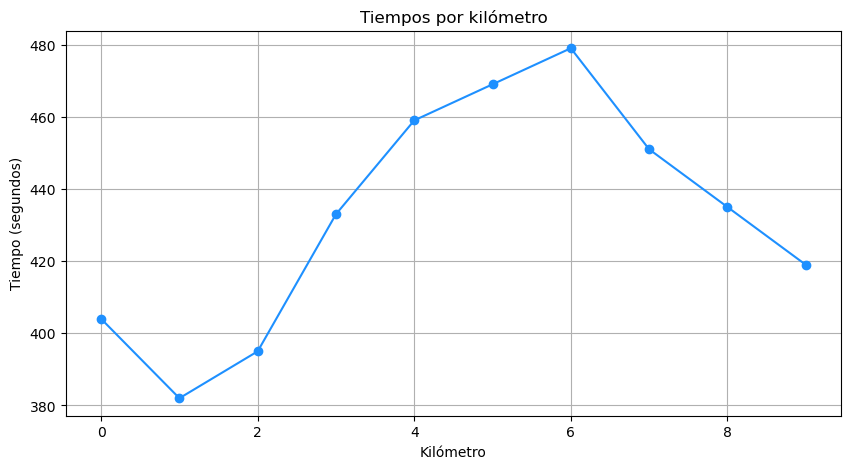

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(splits, marker='o', linestyle='-', color='dodgerblue')
plt.title("Tiempos por kilómetro")
plt.xlabel("Kilómetro")
plt.ylabel("Tiempo (segundos)")
plt.grid(True)
plt.show()


<h3>kilómetro más rápido y más lento</h3>

In [39]:
pace_per_km = [s / 60 for s in splits]  # pasa a minutos


In [41]:
fastest_idx = pace_per_km.index(min(pace_per_km))
slowest_idx = pace_per_km.index(max(pace_per_km))


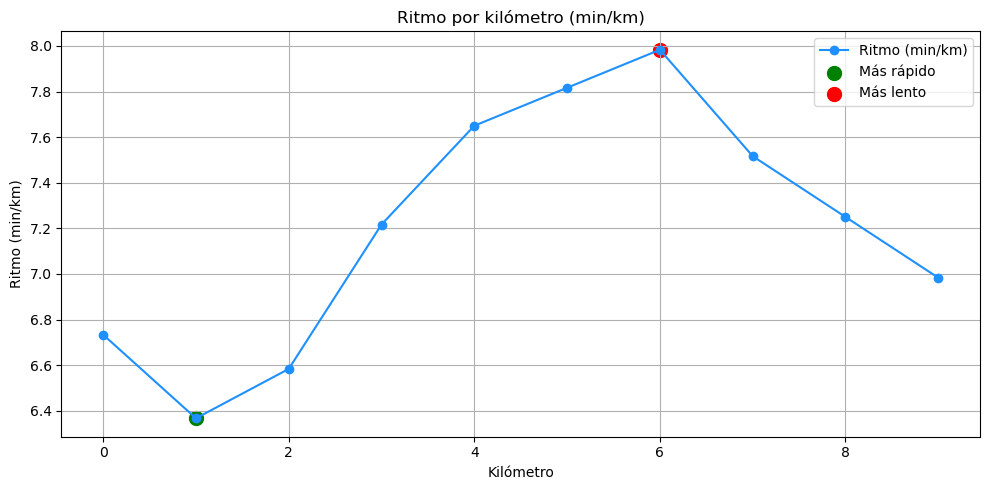

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pace_per_km, marker='o', linestyle='-', color='dodgerblue', label='Ritmo (min/km)')

# Marcar el más rápido (verde) y más lento (rojo)
plt.scatter(fastest_idx, pace_per_km[fastest_idx], color='green', s=100, label='Más rápido')
plt.scatter(slowest_idx, pace_per_km[slowest_idx], color='red', s=100, label='Más lento')

plt.title("Ritmo por kilómetro (min/km)")
plt.xlabel("Kilómetro")
plt.ylabel("Ritmo (min/km)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h2>4. Elevación </h2>

In [49]:
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'lat': point.latitude,
                'lon': point.longitude,
                'time': point.time,
                'ele': point.elevation
            })


In [51]:
from geopy.distance import geodesic

splits = []
pace_per_km = []
elevations = []

distance = 0
start_time = points[0]['time']
elev_accum = []

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]

    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    distance += dist
    elev_accum.append(curr['ele'])

    if distance >= 1.0:
        time_diff = (curr['time'] - start_time).total_seconds()
        splits.append(time_diff)
        pace_per_km.append(time_diff / 60)
        elevations.append(sum(elev_accum) / len(elev_accum))  # elevación promedio

        # reset
        distance = 0
        elev_accum = []
        start_time = curr['time']


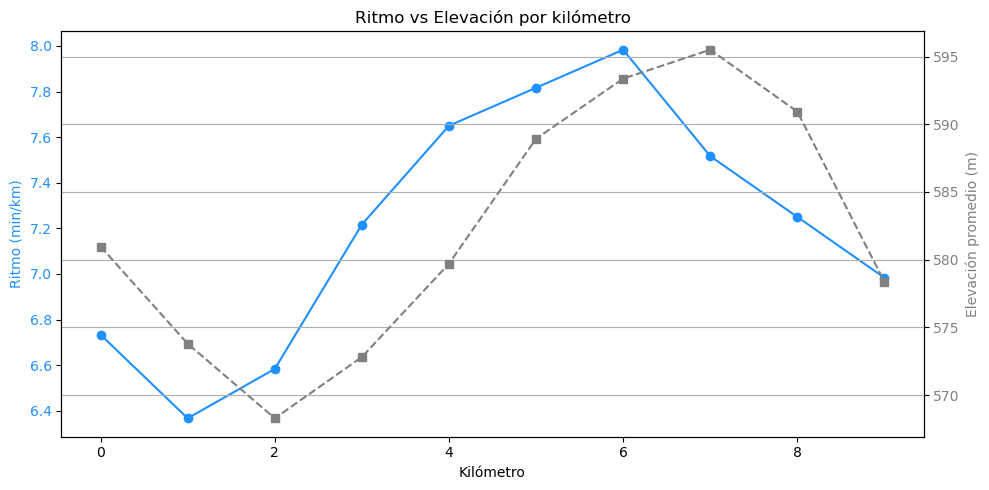

In [53]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Ritmo (eje izquierdo)
ax1.plot(pace_per_km, 'dodgerblue', marker='o', label='Ritmo (min/km)')
ax1.set_xlabel('Kilómetro')
ax1.set_ylabel('Ritmo (min/km)', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Elevación (eje derecho)
ax2 = ax1.twinx()
ax2.plot(elevations, 'gray', marker='s', linestyle='--', label='Elevación prom. (m)')
ax2.set_ylabel('Elevación promedio (m)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Ritmo vs Elevación por kilómetro')
fig.tight_layout()
plt.grid(True)
plt.show()


<h2>Mapa con los kilometros</h2>

In [57]:
from geopy.distance import geodesic

km_markers = []
distancia_acumulada = 0
ultimo_km = 0
prev = None

for i, point in enumerate(points):
    curr = (point['lat'], point['lon'])
    if prev:
        distancia_acumulada += geodesic(prev, curr).km
        if distancia_acumulada - ultimo_km >= 1.0:
            km_label = int(distancia_acumulada)
            km_markers.append((km_label, curr))
            ultimo_km = km_label
    prev = curr


In [59]:
for km, coords in km_markers:
    folium.Marker(
        location=coords,
        icon=folium.DivIcon(
            html=f"""
                <div style="font-size: 10pt; font-weight: bold; color: white;
                            background-color: black; padding: 2px 4px; border-radius: 4px;">
                    {km}K
                </div>
            """
        ),
        tooltip=f"Km {km}"
    ).add_to(mapa)


In [63]:
# Guardar mapa en HTML
mapa.save("10k_ascis_coloreado_por_velocidad.html")

<h2>Mapa con kilometros y tiempo acumulado</h2>

In [65]:
from geopy.distance import geodesic

km_markers = []
distancia_acumulada = 0
ultimo_km = 0
prev = None
start_time = points[0]['time']

for i, point in enumerate(points):
    curr = (point['lat'], point['lon'])
    curr_time = point['time']
    if prev:
        distancia_acumulada += geodesic(prev, curr).km
        if distancia_acumulada - ultimo_km >= 1.0:
            km_label = int(distancia_acumulada)
            tiempo_acumulado = curr_time - start_time
            tiempo_str = str(tiempo_acumulado).split('.')[0]  # Quitar microsegundos
            km_markers.append((km_label, curr, tiempo_str))
            ultimo_km = km_label
    prev = curr


In [67]:
for km, coords, tiempo in km_markers:
    folium.Marker(
        location=coords,
        icon=folium.DivIcon(
            html=f"""
                <div style="font-size: 10pt; font-weight: bold; color: white;
                            background-color: #1f77b4; padding: 2px 4px; border-radius: 4px;">
                    {km}K<br>{tiempo}
                </div>
            """
        ),
        tooltip=f"Km {km} - {tiempo}"
    ).add_to(mapa)


In [69]:
# Guardar mapa en HTML
mapa.save("10k_ascis_coloreado_por_velocidad.html")

<h2>Más gráficos</h2>

In [59]:
km_markers = []
distancia_acumulada = 0
ultimo_km = 0
prev = None
start_time = points[0]['time']

for i, point in enumerate(points):
    curr = (point['lat'], point['lon'])
    curr_time = point['time']
    if prev:
        distancia_acumulada += geodesic(prev, curr).km
        if distancia_acumulada - ultimo_km >= 1.0:
            km_label = int(distancia_acumulada)
            tiempo_acumulado = curr_time - start_time
            tiempo_str = str(tiempo_acumulado).split('.')[0]  # hh:mm:ss
            km_markers.append((km_label, curr, tiempo_acumulado))
            ultimo_km = km_label
    prev = curr



In [61]:
splits = []
for i in range(1, len(km_markers)):
    tiempo_prev = km_markers[i - 1][2]
    tiempo_actual = km_markers[i][2]
    split = tiempo_actual - tiempo_prev
    splits.append(split.total_seconds() / 60)  # en minutos


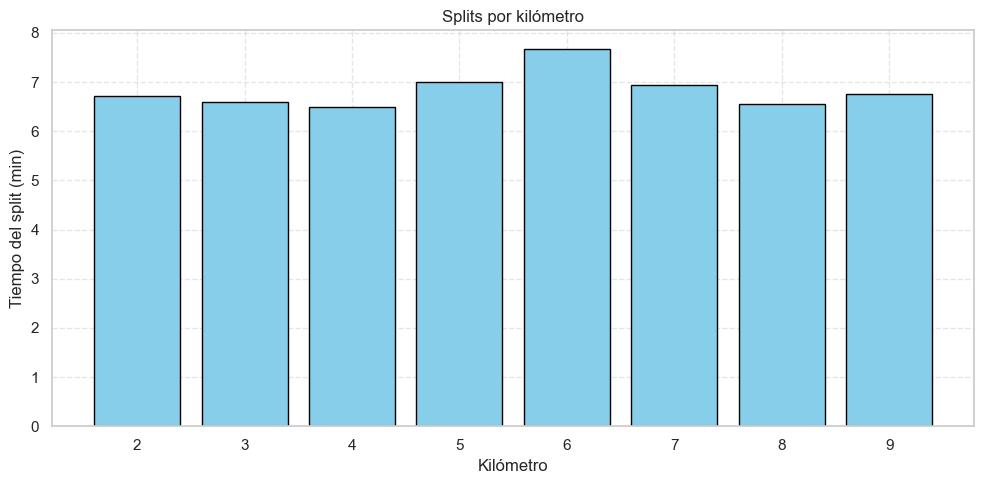

In [63]:
import matplotlib.pyplot as plt

kms = list(range(2, len(km_markers)+1))  # km 2 al último
plt.figure(figsize=(10, 5))
plt.bar(kms, splits, color='skyblue', edgecolor='black')
plt.xlabel("Kilómetro")
plt.ylabel("Tiempo del split (min)")
plt.title("Splits por kilómetro")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(kms)
plt.tight_layout()
plt.show()



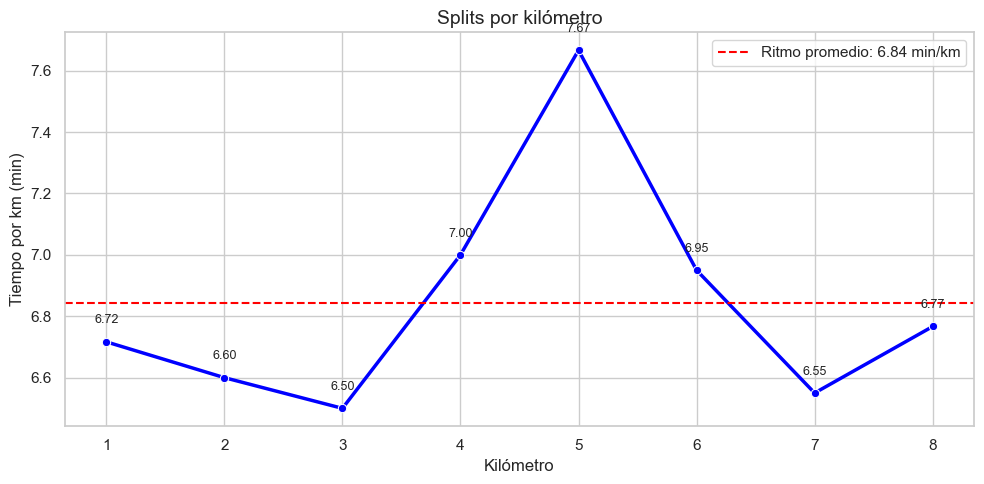

🏁 Ritmo promedio: 6.84 min/km


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponemos que 'splits' ya existe: lista con tiempo por kilómetro en minutos
# Por ejemplo: splits = [5.23, 5.15, 5.40, ..., 5.05]

# Crear DataFrame
df_splits = pd.DataFrame({
    'km': list(range(1, len(splits) + 1)),
    'split_min': splits
})

# Calcular ritmo promedio (min/km)
ritmo_promedio = sum(splits) / len(splits)

# Gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=df_splits, x='km', y='split_min', marker='o', color='blue', linewidth=2.5)

# Etiquetas de puntos
for i, row in df_splits.iterrows():
    plt.text(row['km'], row['split_min'] + 0.05, f"{row['split_min']:.2f}", 
             ha='center', va='bottom', fontsize=9)

# Línea horizontal de ritmo promedio
plt.axhline(ritmo_promedio, color='red', linestyle='--', linewidth=1.5, label=f'Ritmo promedio: {ritmo_promedio:.2f} min/km')

# Títulos y leyenda
plt.title("Splits por kilómetro", fontsize=14)
plt.xlabel("Kilómetro")
plt.ylabel("Tiempo por km (min)")
plt.xticks(df_splits['km'])
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar en consola
print(f"🏁 Ritmo promedio: {ritmo_promedio:.2f} min/km")


In [67]:
# Cálculo del ritmo promedio
total_time_sec = sum([s * 60 for s in splits])  # tiempo total en segundos
total_km = len(splits)
pace_avg_min_km = total_time_sec / 60 / total_km  # en min/km

print(f"Ritmo promedio: {pace_avg_min_km:.2f} min/km")


Ritmo promedio: 6.84 min/km


<h2>Resumen</h2>

In [37]:
from geopy.distance import geodesic
from datetime import timedelta

total_distance = 0
total_up = 0
total_down = 0
elev_prev = None

start_time = points[0]['time']
end_time = points[-1]['time']

for i in range(1, len(points)):
    prev = points[i-1]
    curr = points[i]
    
    # Distancia
    dist = geodesic((prev['lat'], prev['lon']), (curr['lat'], curr['lon'])).kilometers
    total_distance += dist
    
    # Elevación
    elev = curr.get('ele')
    if elev is not None and elev_prev is not None:
        diff = elev - elev_prev
        if diff > 0:
            total_up += diff
        else:
            total_down += abs(diff)
    elev_prev = elev

total_time = end_time - start_time
avg_pace = (total_time.total_seconds() / 60) / total_distance


In [39]:
print(f"Duración total: {total_time}")
print(f"Distancia total: {total_distance:.2f} km")
print(f"Ritmo promedio: {avg_pace:.2f} min/km")
print(f"Ganancia de elevación: {total_up:.1f} m")
print(f"Pérdida de elevación: {total_down:.1f} m")
print(f"Número de puntos GPS: {len(points)}")


Duración total: 1:06:51
Distancia total: 9.96 km
Ritmo promedio: 6.71 min/km
Ganancia de elevación: 55.0 m
Pérdida de elevación: 54.4 m
Número de puntos GPS: 4005


## ✅ Conclusiones

- Ritmo sostenido en los primeros kilómetros, con leve aceleración al final → split negativo.
- Elevación moderada en el km 3 a 4, lo que impactó temporalmente el ritmo.
- Buen rendimiento general. ¡A seguir entrenando! 💪
